# Exploratory Data Analysis


In [77]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
import numpy as np

import torch
from transformers import pipeline



In [78]:

df = pd.read_json(
    "https://huggingface.co/datasets/copenlu/scientific-exaggeration-detection/resolve/main/train.jsonl",
    lines=True)

In [79]:
df

,original_file_id,press_release_conclusion,press_release_strength,abstract_conclusion,abstract_strength,exaggeration_label
0,25-002,Use of the urgent referral pathway (often call...,3,Use of the urgent referral pathway could be ef...,2,exaggerates
1,22-001,Dementia patients from more affluent areas in ...,1,Least deprived patients were 25% more likely t...,1,same
2,26-002,Meeting patients' preferences for the time and...,2,People who reported preferences that were not ...,1,exaggerates
3,19-11-004-1,Crossing your arms relieves pain,3,Besides studies showing relief of phantom limb...,2,exaggerates
4,25-027,Oral contraceptive use just before or during p...,0,"Residual confounding was possible, and the ana...",0,same
...,...,...,...,...,...,...
95,22-006,People bereaved by the sudden death of a frien...,1,Bereavement by suicide is a specific risk fact...,1,same
96,20-11-005-1,Infants who have problems with persistent cryi...,1,The meta-analyses suggest that children with p...,1,same
97,14-11-029-1,Simple test to help diagnose bowel and pancrea...,3,The algorithm has good discrimination and cali...,2,exaggerates
98,03-11-035-1,Scientists identify cause of severe hypoglycaemia,3,"In heterologous cells, the mutant AKT2 was con...",3,same


In [80]:
df['exaggeration_label'].value_counts()

exaggeration_label
same           61
exaggerates    22
downplays      17
Name: count, dtype: int64

In [81]:
df["string_counts"] = df["press_release_conclusion"].str.len()

df_sorted = df.sort_values("string_counts", ascending=False)[
    ["press_release_conclusion", "string_counts"]
]

df_sorted.head(10)

,press_release_conclusion,string_counts
86,“Our results show that reducing the amount of ...,544
5,Scientists at the UCL Institute of Ophthalmolo...,488
43,"The study, led by Dr Jonathan Banks from the U...",441
27,In the first functional MRI brain scan study t...,383
23,Scientists have identified a protein that acts...,336
78,Pregnant women would be willing to trial mater...,294
2,Meeting patients' preferences for the time and...,282
95,People bereaved by the sudden death of a frien...,282
51,Plain cigarette packaging could help prevent p...,277
1,Dementia patients from more affluent areas in ...,277


In [82]:
s = df["press_release_conclusion"].str.len()

stats = s.describe(percentiles=[0.5, 0.9, 0.95, 0.99]).to_frame(name="press_release_conclusion_len")
stats

,press_release_conclusion_len
count,100.000000
mean,175.570000
std,95.838801
min,17.000000
50%,183.000000
90%,275.200000
95%,296.100000
99%,488.560000
max,544.000000


In [83]:
text_cols = ["press_release_conclusion", "abstract_conclusion"]

length_summary = {}
for c in text_cols:
    lens = df[c].str.len()
    length_summary[c] = {
        "min": int(lens.min()),
        "mean": float(lens.mean()),
        "p50": float(lens.quantile(0.50)),
        "p90": float(lens.quantile(0.90)),
        "p95": float(lens.quantile(0.95)),
        "p99": float(lens.quantile(0.99)),
        "max": int(lens.max()),
    }

pd.DataFrame(length_summary).T


,min,mean,p50,p90,p95,p99,max
press_release_conclusion,17.0,175.57,183.0,275.2,296.10,488.56,544.0
abstract_conclusion,51.0,166.88,167.0,241.1,260.65,308.44,352.0


In [84]:
#Worse outliers
df.loc[df["press_release_conclusion"].str.len().nlargest(20).index,
       ["press_release_conclusion", "abstract_conclusion"]]


,press_release_conclusion,abstract_conclusion
86,“Our results show that reducing the amount of ...,"In particular, VEGF was found to regulate cell..."
5,Scientists at the UCL Institute of Ophthalmolo...,These results provide a mechanistic understand...
43,"The study, led by Dr Jonathan Banks from the U...",The low take-up following the mail-out of an i...
27,In the first functional MRI brain scan study t...,We demonstrated that children exposed to famil...
23,Scientists have identified a protein that acts...,High expression of IRF5 was characteristic of ...
78,Pregnant women would be willing to trial mater...,This study did not identify any fundamental or...
2,Meeting patients' preferences for the time and...,People who reported preferences that were not ...
95,People bereaved by the sudden death of a frien...,Bereavement by suicide is a specific risk fact...
1,Dementia patients from more affluent areas in ...,Least deprived patients were 25% more likely t...
51,Plain cigarette packaging could help prevent p...,Among non-smokers and non-daily cigarette smok...


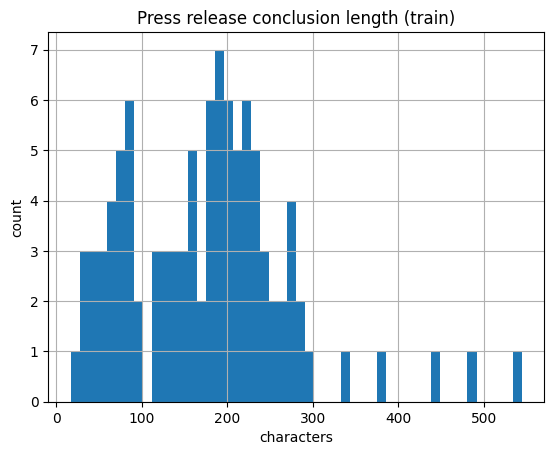

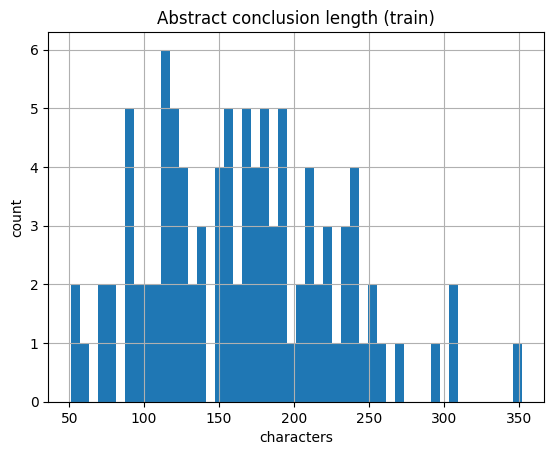

In [85]:
# lengths (characters)
df["pr_len"]  = df["press_release_conclusion"].astype(str).str.len()
df["abs_len"] = df["abstract_conclusion"].astype(str).str.len()

# press release conclusion length distribution
df["pr_len"].hist(bins=50)
plt.title("Press release conclusion length (train)")
plt.xlabel("characters")
plt.ylabel("count")
plt.show()

# abstract conclusion length distribution
df["abs_len"].hist(bins=50)
plt.title("Abstract conclusion length (train)")
plt.xlabel("characters")
plt.ylabel("count")
plt.show()


In [86]:
#Looking for raw sequence lengths no special tokens, padding truncation or masks. This should give guidance for assigning MAX_SEQUENCE and truncation
#Roberta-base
roberta_tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base")

sample = df[["press_release_conclusion", "abstract_conclusion"]]

def paired_sequence(pr, ab):
    enc = roberta_tokenizer(
        list(ab),                 # abstract sequence
        list(pr),                 # press release sequence
        add_special_tokens=True,
        truncation=False,
        padding=False,
        return_attention_mask=False
    )
    return (np.array([len(x) for x in enc["input_ids"]]),enc)
    

sequence_lengths = paired_sequence(sample["press_release_conclusion"], sample["abstract_conclusion"])[0]
raw_sequence_lengths = paired_sequence(sample["press_release_conclusion"], sample["abstract_conclusion"])[1]
print(raw_sequence_lengths)
dist_of_base_pair_inputs = np.quantile(sequence_lengths, [0.5, 0.9, 0.95, 0.99]), sequence_lengths.max()

print(f"The sequence length distribution of sequence pairs is {dist_of_base_pair_inputs}")

{'input_ids': [[0, 34447, 9, 5, 9047, 25001, 19165, 115, 28, 20995, 15525, 4, 2, 2, 34447, 9, 5, 9047, 25001, 19165, 36, 34378, 373, 5, 80, 186, 2067, 467, 43, 30, 937, 3464, 13, 1484, 19, 3986, 1668, 16, 6549, 1074, 6, 309, 7, 10, 892, 11, 20, 25289, 863, 42, 186, 4, 2], [0, 10350, 1988, 22632, 1484, 58, 564, 207, 55, 533, 7, 28, 9608, 15, 1475, 12, 417, 6285, 493, 2196, 87, 5, 144, 22632, 36, 25350, 24971, 731, 1750, 112, 4, 1244, 6, 6164, 207, 2123, 22455, 112, 4, 1646, 2383, 134, 4, 2983, 322, 2, 2, 495, 6285, 493, 1484, 31, 55, 24204, 911, 11, 1156, 32, 974, 207, 55, 533, 7, 28, 14255, 1475, 12, 417, 6285, 493, 2196, 87, 1484, 31, 22555, 911, 6, 5684, 10, 92, 121, 7454, 892, 9, 6791, 6, 39664, 12854, 1484, 420, 5, 987, 4, 152, 12768, 21, 45, 450, 11, 3430, 6, 2874, 2487, 50, 5295, 4, 2], [0, 4763, 54, 431, 16953, 14, 58, 45, 1145, 58, 540, 533, 7, 194, 14, 1416, 56, 1147, 106, 19, 49, 1272, 4, 2, 2, 5096, 16382, 1484, 108, 16953, 13, 5, 86, 8, 317, 9, 49, 10947, 1416, 189, 3327, 4

# I want to explore how roberta handles MLM. I'll pass in some press_release_conclusions from the training set to see how it handles the data. 

In [87]:
from transformers import RobertaConfig, RobertaModel

# Initializing a RoBERTa configuration
configuration = RobertaConfig()

# Initializing a model (with random weights) from the configuration
model = RobertaModel(configuration)

# Accessing the model configuration
configuration = model.config

print(model,configuration)

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (position_embeddings): Embedding(512, 768, padding_idx=1)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropou

## I've performed a cloze qa for a double masked sequence from the training set. The first mask predicts the correct word but the second mask is incorrectly predicted. However "finds" and "shows" probably has a high degree of similarity. Let's check the embbeddings next. 

In [88]:


pipeline = pipeline(
    task="fill-mask",
    model="FacebookAI/roberta-base",
    dtype=torch.float16,
    device=0
)
pipeline("Nanotubes pose health <mask>, study <mask>.")

Loading weights: 100%|██████████| 202/202 [00:00<00:00, 1326.92it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              
RobertaForMaskedLM LOAD REPORT from: FacebookAI/roberta-base
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


[[{'score': 0.44482421875,
   'token': 2476,
   'token_str': ' risks',
   'sequence': '<s>Nanotubes pose health risks, study<mask>.</s>'},
  {'score': 0.269775390625,
   'token': 810,
   'token_str': ' risk',
   'sequence': '<s>Nanotubes pose health risk, study<mask>.</s>'},
  {'score': 0.1072998046875,
   'token': 19895,
   'token_str': ' hazard',
   'sequence': '<s>Nanotubes pose health hazard, study<mask>.</s>'},
  {'score': 0.082275390625,
   'token': 1856,
   'token_str': ' threat',
   'sequence': '<s>Nanotubes pose health threat, study<mask>.</s>'},
  {'score': 0.0343017578125,
   'token': 21125,
   'token_str': ' hazards',
   'sequence': '<s>Nanotubes pose health hazards, study<mask>.</s>'}],
 [{'score': 0.374755859375,
   'token': 5684,
   'token_str': ' finds',
   'sequence': '<s>Nanotubes pose health<mask>, study finds.</s>'},
  {'score': 0.227294921875,
   'token': 924,
   'token_str': ' shows',
   'sequence': '<s>Nanotubes pose health<mask>, study shows.</s>'},
  {'score': 